# PyPoT Example Code

This notebook includes example code for performing peaks-over-threshold analysis tasks using PyPoT.

## 1a) simulate Generalized Pareto data and fit distribution parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pypot.generalized_pareto import gp_inv_cdf, fit_GPD, gp_density, gp_neg_loglik, gp_neg_loglik_jacob

In [3]:
# true parameters
XI = -0.20
SIGMA = 0.75
# number of simulations
N_SIM = 10000

u_vals = np.random.uniform(size=N_SIM)
# probability integral transform data
x_vals = gp_inv_cdf(u_vals, XI, SIGMA)

# initial parameter guess
XI_INIT = 1/8
SIGMA_INIT = 1
THETA_0 = (XI_INIT, SIGMA_INIT)

# fit the distribution via MLE (minimizing negative log likelihood)
mle = fit_GPD(x_vals, THETA_0, gp_neg_loglik, gp_neg_loglik_jacob)

print("maximum likelihood estimates of xi, sigma:")
print(mle)

maximum likelihood estimates of xi, sigma:
[-0.19874876  0.74514743]


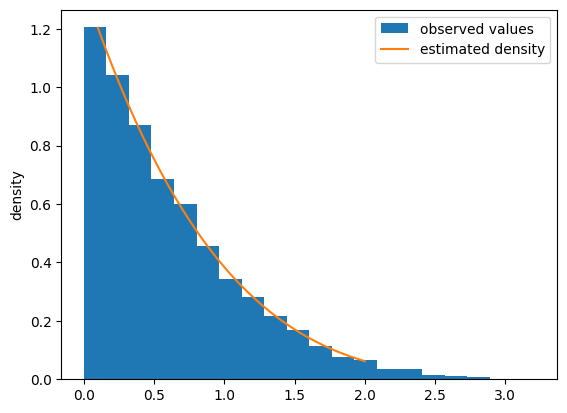

In [5]:
plt.hist(x_vals, density=True, label="observed values", bins=20)

# MLE ESTIMATE
x_plot = np.linspace(0.1, 2, 100)
y_plot = gp_density(x_plot, mle[0], mle[1])
plt.plot(x_plot, y_plot, label="estimated density")
plt.ylabel("density", fontsize=10)
plt.legend()

plt.show()

## 1b) compute confidence intervals for GP parameters

In [6]:
from pypot.generalized_pareto import gp_param_cov_matrix

In [7]:
xi_hat = mle[0]
sigma_hat = mle[1]

# compute covariance matrix of estimators
estimator_cov_mat = gp_param_cov_matrix(xi_hat, sigma_hat, N_SIM)

confint_xi = [xi_hat - 1.96 * np.sqrt(estimator_cov_mat[0][0]), xi_hat + 1.96 * np.sqrt(estimator_cov_mat[0][0])]
print("confidence interval for xi:")
print(confint_xi)

confint_sigma = [sigma_hat - 1.96 * np.sqrt(estimator_cov_mat[1][1]), sigma_hat + 1.96 * np.sqrt(estimator_cov_mat[1][1])]
print("confidence interval for sigma:")
print(confint_sigma)


confidence interval for xi:
[-0.21795775227614164, -0.17953977374304855]
confidence interval for sigma:
[0.7266591058699173, 0.763635761742251]


## 2a) load example time series dataset and automatically find threshold via ForwardStop algorithm

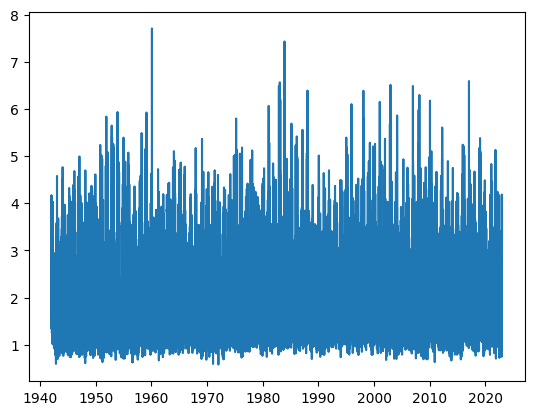

In [22]:
from pypot.utils import fetch_example_dataset
import matplotlib.pyplot as plt

series = fetch_example_dataset()
plt.plot(series.index, series)
plt.show()

In [30]:
from pypot.threshold_selection import forward_stop_u_selection, run_AD_tests
from pypot.threshold_selection import forward_stop_adjusted_p
from pypot.return_levels import lambda_hat, r_hat, var_hat_r_l
from pypot.utils import years_span_series

# from pypot.utils import get_extremes_peaks_over_threshold
# from pypot.generalized_pareto import gp_neg_loglik, gp_neg_loglik_jacob, fit_GPD
# from pypot.threshold_selection import log_interpolate_p


In [26]:
# set lower threshold bound at 99th quantile
lower = round(series.quantile(0.99), 2)
print("lower threshold search bound:")
print(lower)

# round down from max for upper bound
upper = "%.2f" % max(series)
upper = float(upper)
print("upper threshold search bound:")
print(upper)

# set number of thresholds to search
l = 10

selected_thresh, theta_hat = forward_stop_u_selection(series, lower, upper, l, "72h", alpha=0.05)

print("selected threshold:")
print(selected_thresh)

print("mle at selected threshold:")
print(theta_hat)

lower threshold search bound:
4.03
upper threshold search bound:
7.71
selected threshold:
4.03
mle at selected threshold:
[-0.03725332  0.62195683]


## 2b) compute return levels and confidence intervals for selected threshold

In [32]:
# initial point for optimizer
XI_INIT = 1/5
SIGMA_INIT = 1
THETA_0 = (XI_INIT, SIGMA_INIT)

# initial point for optimizer
u = selected_thresh

# independence definition
r = "72h"

extremes = get_extremes_peaks_over_threshold(
    series,
    u,
    r
)

# Poisson process lambda MLE
l_hat = lambda_hat(extremes)
print("mle for lambda:")
print(l_hat)

mle for lambda:
4.60902770729727


In [36]:
# return period
L = 50

r_hat_50 = r_hat(L, l_hat, xi_hat, sigma_hat)
print(f"estimated {L} year return value:")
# add back the subtracted threshold
print(r_hat_50 + u)

# sample size
n = len(extremes)
# time spanned by the series in years
t = years_span_series(series)
print("sample size:")
print(n)
print("years span:")
print(t)

# asymptotic variance of 50 year return value
var_L = var_hat_r_l(l_hat, xi_hat, sigma_hat, n, t, L)

sd = np.sqrt(var_L)

print(f"{L} year return variance:")
print(var_L)
print(f"{L} year standard deviation")
print(sd)

# compute 90% confidence interval
Z_SCORE = 1.645

lower_bound = u + r_hat_50 -  Z_SCORE * sd
upper_bound = u + r_hat_50 + Z_SCORE * sd

print(f"{L} year return value:")
print(u + r_hat_50)

print("90% CI:")
print(lower_bound)
print(upper_bound)


estimated 50 year return value:
5.680546184053492
sample size:
373
years span:
80.99657768651609
50 year return variance:
[[0.02683916]]
50 year standard deviation
[[0.16382662]]
50 year return value:
5.680546184053492
90% CI:
[[5.4110514]]
[[5.95004097]]
